In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
import warnings
warnings.filterwarnings('ignore')

## 1. Case report data

In [17]:
# load data
df = pd.read_csv("data/cases_test.csv")
df

,report_date,fips,region,vdh_health_district,locality,Population,total_cases,hospitalizations,deaths,new_cases,new_hosp,new_deaths,weekly_rolling_avg_cases,rate_per_100000
0,2020-03-17,51041,central,Chesterfield,Chesterfield,343551,4,2,0,4.0,2.0,0.0,NaN,NaN
1,2020-03-18,51041,central,Chesterfield,Chesterfield,343551,5,2,0,1.0,0.0,0.0,NaN,NaN
2,2020-03-19,51041,central,Chesterfield,Chesterfield,343551,6,3,0,1.0,1.0,0.0,NaN,NaN
3,2020-03-20,51041,central,Chesterfield,Chesterfield,343551,5,1,0,0.0,0.0,0.0,NaN,NaN
4,2020-03-21,51041,central,Chesterfield,Chesterfield,343551,7,1,0,2.0,0.0,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61308,2021-06-16,51141,southwest,West Piedmont,Patrick,17748,1391,110,43,0.0,0.0,0.0,0.285714,1.610
61309,2021-06-17,51141,southwest,West Piedmont,Patrick,17748,1393,111,43,2.0,1.0,0.0,0.571429,3.220
61310,2021-06-18,51141,southwest,West Piedmont,Patrick,17748,1393,111,43,0.0,0.0,0.0,0.571429,3.220
61311,2021-06-19,51141,southwest,West Piedmont,Patrick,17748,1393,112,43,0.0,1.0,0.0,0.428571,2.415


In [18]:
df['report_date'] = pd.to_datetime(df.report_date)
regions = list(pd.unique(df.region.values))
districts = list(pd.unique(df.vdh_health_district.values))
county = list(pd.unique(df.locality.values))
fips = list(pd.unique(df.fips.values))

In [19]:
print(len(regions))
print(len(districts))
print(len(county))
print(len(fips))

5
35
133
133


In [6]:
# stats
# total cases, hospitalization, deaths
# viz graph
# rolling weekly incidence average with threshold
# 

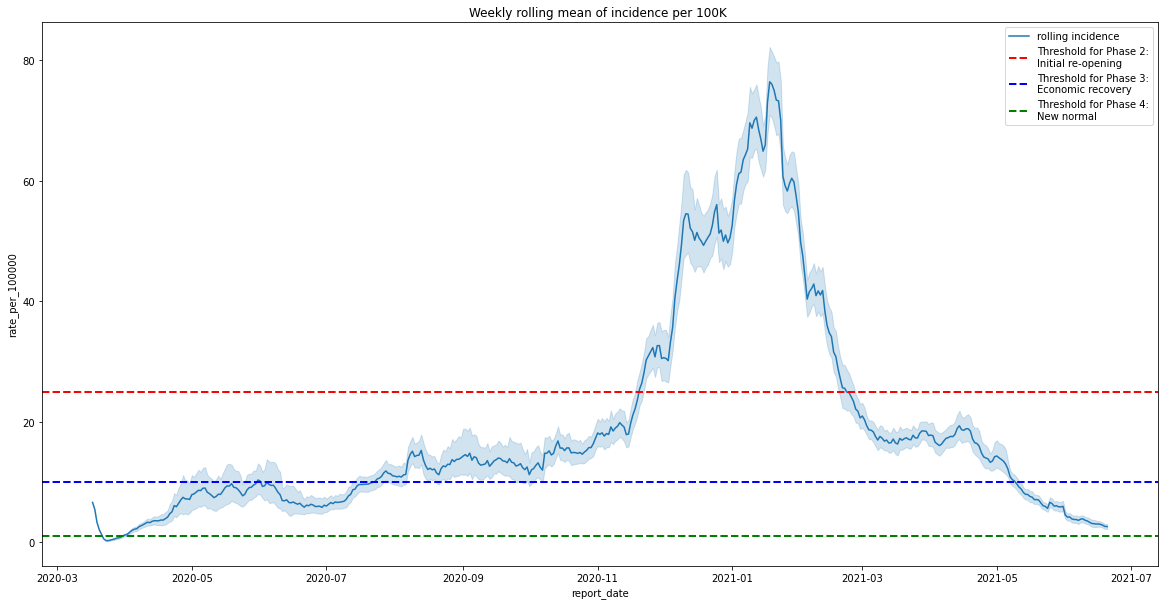

In [6]:
fig, ax = plt.subplots(figsize=(20,10))
ax = sns.lineplot(df.report_date, df.rate_per_100000, label='rolling incidence')
ax.axhline(y = 25,  linewidth=2, color='r', ls = '--', label="Threshold for Phase 2:\nInitial re-opening")
ax.axhline(y = 10,  linewidth=2, color='b', ls = '--', label="Threshold for Phase 3:\nEconomic recovery")
ax.axhline(y = 1,  linewidth=2, color='g', ls = '--', label="Threshold for Phase 4:\nNew normal")
ax.set_title("Weekly rolling mean of incidence per 100K ")
ax.legend(fontsize = 10)
plt.show()

In [6]:
# cumulative counts
cumulative_df = (df
.groupby(['report_date'])
['total_cases','hospitalizations','deaths'].sum()
.reset_index()
.sort_values('total_cases', ascending=False))

In [7]:
print('total cases: ', cumulative_df.total_cases.max())
print('total hospitalizations: ', cumulative_df.hospitalizations.max())
print('total deaths: ', cumulative_df.deaths.max())

total cases:  678649
total hospitalizations:  30317
total deaths:  11351


In [8]:
from urllib.request import urlopen
import json
with urlopen('https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json') as response:
    counties = json.load(response)

In [9]:
import plotly.express as px
from plotly.offline import plot

In [26]:
new_df = (df
.groupby(['fips','locality','report_date'])
['total_cases','hospitalizations','deaths',''].sum()
.reset_index())

fig = px.choropleth(new_df, geojson=counties,
                    locations='fips',
                    color='total_cases',
                    color_continuous_scale='viridis',
                    range_color=(0,new_df.total_cases.max()),
                    scope='usa',
                    hover_name='locality',
                    hover_data=['total_cases','hospitalizations','deaths'])
fig.update_geos(fitbounds="locations",visible=False)
plot(fig)

'temp-plot.html'

In [147]:
cases_map = df.groupby(['fips','locality'])['total_cases','hospitalizations','deaths'].max().reset_index()
cases_map

,fips,locality,total_cases,hospitalizations,deaths
0,51001,Accomack,2868,212,45
1,51003,Albemarle,5817,235,85
2,51005,Alleghany,1372,64,49
3,51007,Amelia,927,54,36
4,51009,Amherst,2980,127,40
...,...,...,...,...,...
128,51800,Suffolk,8002,461,191
129,51810,Virginia Beach,36318,1704,413
130,51820,Waynesboro,2396,73,38
131,51830,Williamsburg,772,29,13


In [148]:
def display_case_map(measure):
    fig = px.choropleth(cases_map, geojson=counties,
                        locations='fips',
                        color=measure,
                        color_continuous_scale='viridis',
                        range_color=(0,cases_map[measure].max()*0.75),
                        scope='usa',
                        hover_name='locality',
                        hover_data=['total_cases','hospitalizations','deaths'])
    fig.update_geos(fitbounds="locations",visible=False)
    fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
    return fig

In [149]:
plot(display_case_map('total_cases'))

'temp-plot.html'

## 2. Vaccine Report

In [27]:
vax = pd.read_csv('data/vax_test.csv')

In [28]:
vax.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 261423 entries, 0 to 261422
Data columns (total 10 columns):
 #   Column                      Non-Null Count   Dtype 
---  ------                      --------------   ----- 
 0   administration_date         261421 non-null  object
 1   fips                        261423 non-null  object
 2   locality                    261423 non-null  object
 3   health_district             261423 non-null  object
 4   facility_type               261423 non-null  object
 5   vaccine_manufacturer        261423 non-null  object
 6   dose_number                 261423 non-null  int64 
 7   vaccine_doses_administered  261423 non-null  int64 
 8   Population                  261423 non-null  int64 
 9   region                      261423 non-null  object
dtypes: int64(3), object(7)
memory usage: 19.9+ MB


In [33]:
vax['administration_date'] = pd.to_datetime(vax.administration_date)

In [85]:
print("total_doses: ", vax.vaccine_doses_administered.sum())
print("at least one dose: ", vax[vax.dose_number ==1].vaccine_doses_administered.sum())
print("two doses: ", vax[vax.dose_number ==2].vaccine_doses_administered.sum())
print("fully vaccinated: ", vax[vax.dose_number ==2].vaccine_doses_administered.sum()+vax[(vax.dose_number ==1) & (vax.vaccine_manufacturer =='J&J')].vaccine_doses_administered.sum())

total_doses:  8833655
at least one dose:  4929523
two doses:  3904132
fully vaccinated:  4201439


In [81]:
#new vaccine doses
vax[(vax.administration_date.notnull())].groupby(['administration_date']).vaccine_doses_administered.sum().iloc[-1]

5371

In [98]:
#VA state population
va_pop = vax[(vax.administration_date.notnull())].groupby(['fips']).Population.max().sum()
va_pop

8454463

In [103]:
#first dose population percentage
str(round(vax[vax.dose_number ==1].vaccine_doses_administered.sum()/va_pop *100,1))+'%'

'58.3%'

In [104]:
#full vax population percentage
str(round((vax[vax.dose_number ==2].vaccine_doses_administered.sum()+vax[(vax.dose_number ==1) & (vax.vaccine_manufacturer =='J&J')].vaccine_doses_administered.sum())/va_pop *100,1))+'%'

'49.7%'

In [137]:
vax_2 = pd.read_csv('data/county_vax.csv')
vax_2['administration_date'] = pd.to_datetime(vax_2.administration_date)
vax_2

,administration_date,fips,region,health_district,locality,Population,facility_type,vaccine_manufacturer,dose_number,vaccine_doses_administered,pop_perc,weekly_rolling_avg_dose
0,2020-12-15,51041,central,Chesterfield,Chesterfield,343551,Hospitals,Moderna,1,1,0.000291,NaN
1,2020-12-15,51041,central,Chesterfield,Chesterfield,343551,Hospitals,Pfizer,1,52,0.015136,NaN
2,2020-12-15,51041,central,Chesterfield,Chesterfield,343551,Medical Practices,Pfizer,1,1,0.000291,NaN
3,2020-12-16,51041,central,Chesterfield,Chesterfield,343551,Medical Practices,Pfizer,1,9,0.002620,NaN
4,2020-12-16,51041,central,Chesterfield,Chesterfield,343551,Hospitals,Pfizer,1,309,0.089943,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
254291,2021-06-18,51141,southwest,West Piedmont,Patrick,17748,Pharmacies,J&J,1,5,0.028172,3.000000
254292,2021-06-18,51141,southwest,West Piedmont,Patrick,17748,Other Community Health Providers,Moderna,1,1,0.005634,3.000000
254293,2021-06-19,51141,southwest,West Piedmont,Patrick,17748,Pharmacies,Pfizer,1,2,0.011269,3.142857
254294,2021-06-19,51141,southwest,West Piedmont,Patrick,17748,Pharmacies,J&J,1,3,0.016903,2.857143


In [145]:
map_df = (vax_2
.groupby(['fips','locality'])
['vaccine_doses_administered', 'pop_perc'].sum()
.reset_index())

fig = px.choropleth(map_df, geojson=counties,
                    locations='fips',
                    color='pop_perc',
                    color_continuous_scale='viridis',
                    range_color=(0,100),
                    scope='usa',
                    hover_name='locality',
                    hover_data=['vaccine_doses_administered', 'pop_perc'])
fig.update_geos(fitbounds="locations",visible=False)
plot(fig)

'temp-plot.html'